# Getting started

## Fitting a neutron reflectometry dataset

We start off with all the relevant imports we'll need.

In [1]:
%matplotlib inline
from __future__ import print_function, division

import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel

It's important to note down the versions of the software that you're using, in order for the analysis to be reproducible.

In [2]:
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version, scipy.version.version, np.version.version))

refnx: 0.0.16.dev0+e7fc2a0
scipy: 1.1.0
numpy: 1.14.5


The dataset we're going to use as an example is distributed with every install. The following cell determines its location.

In [3]:
pth = os.path.dirname(refnx.__file__)
DATASET_NAME = 'c_PLP0011859_q.txt'
file_path = os.path.join(pth, 'analysis', 'test', DATASET_NAME)

Now we load the dataset into a `ReflectDataset`.

In [4]:
data = ReflectDataset(file_path)

Now we create a series of `SLD` objects representing each of the materials.

In [5]:
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.0, name='film')
d2o = SLD(6.36, name='d2o')

We create `Slab`s from these `SLD`s to represent each layer in the system.

In [6]:
# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(30, 3)

# the film of interest
film_layer = film(250, 3)

# layer for the solvent
d2o_layer = d2o(0, 3)

Now we specify which parameters are going to vary in a fit, and what the limits are on those parameters:

In [7]:
sio2_layer.thick.setp(bounds=(15, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

film_layer.thick.setp(bounds=(200, 300), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 3), vary=True)
film_layer.rough.setp(bounds=(1, 15), vary=True)

d2o_layer.rough.setp(vary=True, bounds=(1, 15))

A `Structure` is composed from a series of `Component`s. In this case all the components are `Slab`s.

In [8]:
structure = si | sio2_layer | film_layer | d2o_layer

A `Slab` has the following parameters, which are all accessible as attributes:

 - `Slab.thick`
 - `Slab.sld.real`
 - `Slab.sld.imag`
 - `Slab.rough`

In [9]:
print(sio2_layer.parameters)

________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter:'SiO2 - thick' value=      30                 , bounds=[15, 50]>
<Parameter: 'SiO2 - sld'  value=     3.47       (fixed)  , bounds=[-inf, inf]>
<Parameter: 'SiO2 - isld' value=       0        (fixed)  , bounds=[-inf, inf]>
<Parameter:'SiO2 - rough' value=       3                 , bounds=[1, 15]>
<Parameter:'SiO2 - volfrac solvent'value=       0        (fixed)  , bounds=[-inf, inf]>


A `ReflectModel` is made from the `Structure`.`ReflectModel` performs resolution smearing, applies scaling factor and adds a Q-independent constant background. The `ReflectModel` is responsible for calculating the generative model.

In [10]:
model = ReflectModel(structure, bkg=3e-6)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

An `Objective` is made from a `Model` and a `Data`. Here we use a `Transform` to fit as logY vs X.

In [11]:
objective = Objective(model, data, transform=Transform('logY'))

An `Objective` can calculate statistics for the fitting system.

In [12]:
print(objective.chisqr())

34376.690923051545


The final setup setup step is to create a `CurveFitter` from the `Objective`. These objects do the fitting/sampling. Let's do an initial fit with differential evolution.

In [13]:
fitter = CurveFitter(objective)
fitter.fit('differential_evolution')

   covar: array([[ 9.31537946e-06, -6.99696624e-14, -6.40710618e-05,
         1.05997810e-04,  1.28751833e-04,  2.45104562e-05,
        -2.98072630e-04, -1.42445004e-05],
       [-6.99696624e-14,  4.56156555e-16, -1.44015583e-09,
        -5.82976605e-10,  7.21358572e-10, -6.13157112e-11,
         5.35433126e-10,  1.54735949e-09],
       [-6.40710618e-05, -1.44015583e-09,  1.44799438e-01,
        -1.36150013e-02, -8.69606725e-02,  1.62667846e-03,
        -4.62874658e-02, -1.40046638e-02],
       [ 1.05997810e-04, -5.82976605e-10, -1.36150013e-02,
         7.77120373e-02,  1.15810873e-02,  2.19113929e-05,
        -9.53673747e-03, -8.78947896e-03],
       [ 1.28751833e-04,  7.21358572e-10, -8.69606725e-02,
         1.15810873e-02,  6.36263084e-02, -4.84569219e-04,
         1.68695404e-02,  6.46766378e-03],
       [ 2.45104562e-05, -6.13157112e-11,  1.62667846e-03,
         2.19113929e-05, -4.84569219e-04,  1.66759419e-04,
        -2.82567831e-03, -6.84217941e-04],
       [-2.98072630e-04,

An `bjective` has a plot method, which is a quick visualisation. You need matplotlib installed to create a graph.

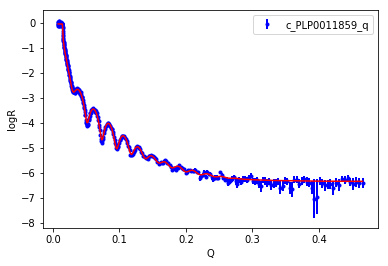

In [14]:
objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

`Structure` has a `sld_profile` method to return the SLD profile. Let's also plot that.

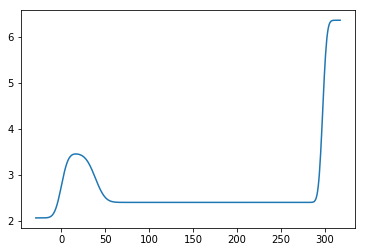

In [15]:
plt.plot(*structure.sld_profile())

Let's see the results of the fit. For the case of DifferentialEvolution uncertainties are estimated by estimating the Hessian/Covariance matrix.

In [16]:
print(objective)

________________________________________________________________________________
Objective - 112221426296
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 920.9855791219641
Weighted = True
Transform = <refnx.analysis.objective.Transform object at 0x1a20eb14a8>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    value=   0.880842     +/- 0.00305, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     value=  4.48687e-07   +/- 2.14e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution'value=       5        (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  value=       0        (

Now lets do a MCMC sampling of the curvefitting system. First we do 400 samples which we then discard (burn). These samples are discarded because the initial chain might not be representative of an equilibrated system (i.e. distributed around the mean with the correct covariance).

In [17]:
fitter.sample(400)
fitter.reset()

100%|██████████| 400/400 [00:58<00:00,  6.95it/s]


Now do a production run, only saving 1 in 100 samples. This is to remove autocorrelation. We save 30 steps, giving a total of 10 * 200 samples (200 walkers is the default).

In [18]:
res = fitter.sample(30, nthin=100, pool=4)

100%|██████████| 3000/3000 [07:07<00:00,  7.25it/s]


In the final output of the sampling each varying parameter is given a set of statistics. `Parameter.value` is the median of the chain samples. `Parameter.stderr` is half the [15, 85] percentile, representing a standard deviation.

In [19]:
print(objective)

________________________________________________________________________________
Objective - 112221426296
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 919.591809587562
Weighted = True
Transform = <refnx.analysis.objective.Transform object at 0x1a20eb14a8>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    value=   0.879367     +/- 0.00299, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     value=  4.59816e-07   +/- 2.23e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution'value=       5        (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  value=       0        (f

A corner plot shows the covariance between parameters.

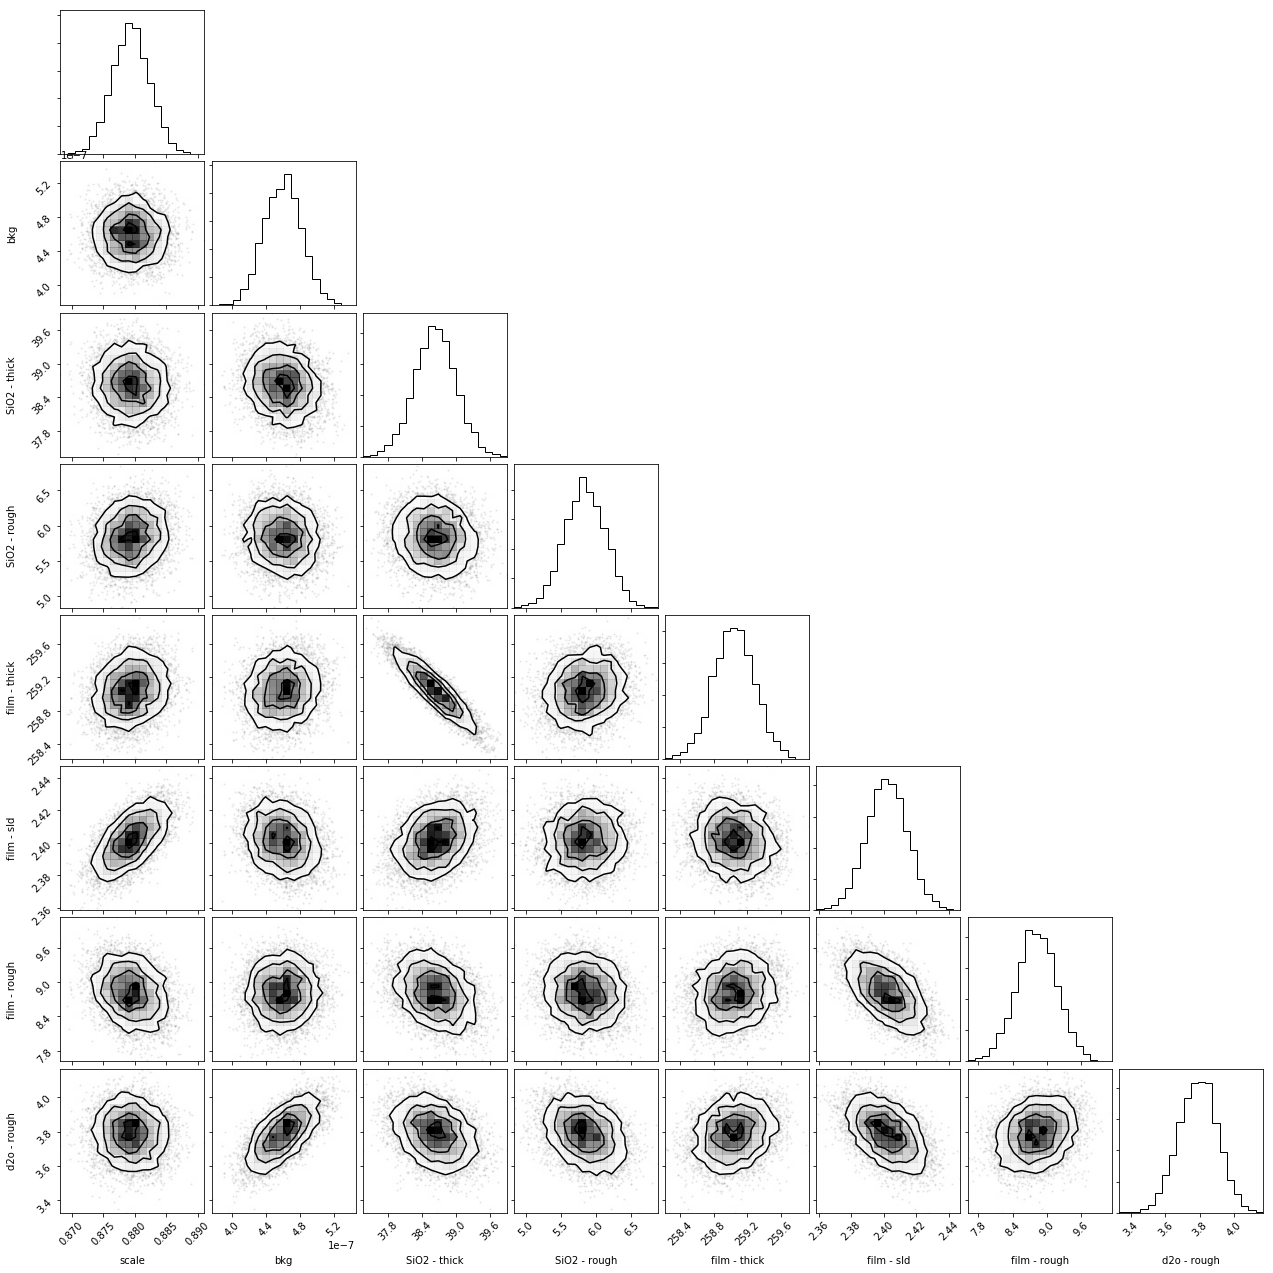

In [20]:
objective.corner();

Once we've done the sampling we can look at the variation in the model at describing the data. In this example there isn't much spread.

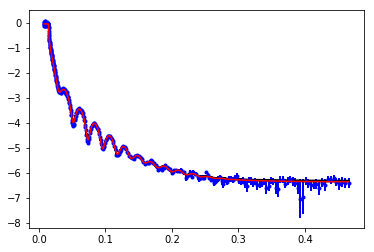

In [21]:
objective.plot(samples=300);

In a similar manner we can look at the spread in SLD profiles consistent with the data. The `objective.pgen` generator yields parameter sets from the chain.

(2.2, 6)

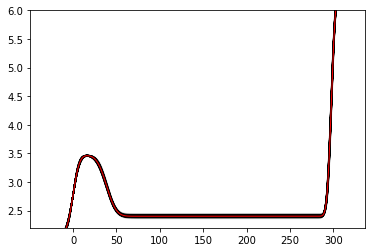

In [22]:
# but first we'll save the parameters in an array.
saved_params = np.array(objective.parameters)

z, true_sld = structure.sld_profile()

for pvec in objective.pgen(ngen=500):
    objective.setp(pvec)
    zs, sld = structure.sld_profile()
    plt.plot(zs, sld, color='k', alpha=0.05)

# put back saved_params
objective.setp(saved_params)

plt.plot(z, true_sld, lw=1, color='r')
plt.ylim(2.2, 6)

## Fitting a data to a user defined model

Here we demonstrate a fit to a user defined model. This line example is taken from the [emcee documentation](http://emcee.readthedocs.io/en/stable/user/line.html) and the reader is referred to that link for more detailed explanation. The errorbars are underestimated, and the modelling will account for that.

First we synthesise some data:

In [23]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

To use *refnx* we need first need to create a dataset.

In [24]:
from refnx.dataset import Data1D
data = Data1D(data=(x, y, yerr))

Then we need to set up a generative model.

In [25]:
def line(x, params, *args, **kwds):
    p_arr = np.array(params)
    return p_arr[0] + x * p_arr[1]

# the model needs parameters
p = Parameter(1, 'b', vary=True, bounds=(0, 10))
p |= Parameter(-2, 'm', vary=True, bounds=(-5, 0.5))

model = Model(p, fitfunc=line)

Now we create an objective from the mode and the data. We use an extra parameter, `lnsigma`, to describe the underestimated error bars.

In [26]:
lnf = Parameter(0, 'lnf', vary=True, bounds=(-10, 1))
objective = Objective(model, data, lnsigma=lnf)

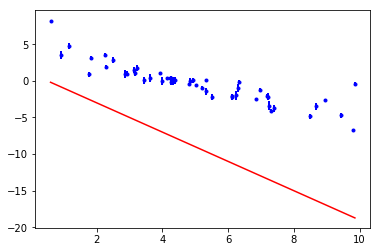

In [27]:
objective.plot();

Create a CurveFitter from the model.

In [28]:
fitter = CurveFitter(objective)
fitter.fit('differential_evolution')

   covar: array([[ 0.042024  , -0.02890108,  0.00634284],
       [-0.02890108,  0.12798988, -0.02746504],
       [ 0.00634284, -0.02746504,  0.00607665]])
     fun: 12.1824139481053
     jac: array([ 9.89430760e-05,  1.13686838e-05, -6.80344669e-05])
 message: 'Optimization terminated successfully.'
    nfev: 1255
     nit: 26
  stderr: array([0.20499756, 0.35775674, 0.07795286])
 success: True
       x: array([-0.79043892,  4.52831535, -1.00300874])

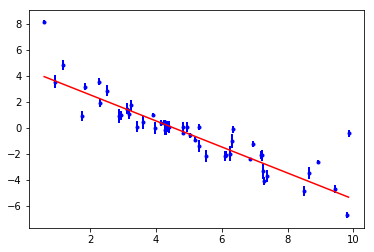

In [29]:
objective.plot();

Now we'll do some MCMC sampling:

In [30]:
fitter.sample(2000);

100%|██████████| 2000/2000 [01:04<00:00, 30.79it/s]


Burn 400 steps and thin by 100.

In [31]:
from refnx.analysis import process_chain

process_chain(objective, fitter.chain, nburn=400, nthin=100, flatchain=True)
print(objective)

________________________________________________________________________________
Objective - 112269420192
Dataset = <refnx.dataset.data1d.Data1D object at 0x1a23c76a90>
datapoints = 50
chi2 = 44.66220411377497
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:      None      
<Parameter:     'lnf'     value=   -0.764314    +/- 0.159, bounds=[-10, 1]>
________________________________________________________________________________
Parameters:      None      
<Parameter:      'b'      value=    4.55118     +/- 0.366, bounds=[0, 10]>
<Parameter:      'm'      value=   -1.00809     +/- 0.0803, bounds=[-5, 0.5]>


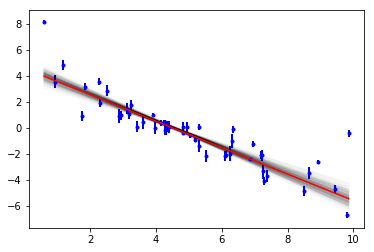

In [32]:
objective.plot(samples=300);